<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/seminar_12_gaussian_mixture_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GMM in 1D

In [0]:
#@title MM of 3 Gaussians
from ipywidgets import HBox, VBox, FloatSlider, FloatRangeSlider
import ipywidgets as widgets
import scipy.stats

words = ['mu_1', 'sigma_1', 'mu_2', 'sigma_2', 'mu_3', 'sigma_3']
mins  = [0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
maxes = [100.0, 10.0, 100.0, 10.0, 100.0, 10.0]
vals  = [10.0, 10.0, 50.0, 10.0, 90.0, 10.0]
sliders = [FloatSlider(description=w, min=n, max=x, value=v) for w,x,n,v in zip(words, maxes, mins, vals)]
pi_slider = FloatRangeSlider(value=[0.3, 0.6], min=0.0, max=1.0, description='pi(1,2,3)')
boxes = [VBox([pi_slider])]
for slider1, slider2 in zip(sliders[::2], sliders[1::2]):
  boxes.append(VBox([slider1, slider2]))

def plot_pdf(pi, mu1, sig1, mu2, sig2, mu3, sig3):
  pi1, pi2 = pi; pi2 -= pi1; pi3 = 1.0 - pi2 - pi1;
  x = np.linspace(0, 100, 1001)
  fig = plt.figure(figsize=(10, 8))
  P_sum = np.zeros(x.shape)
  for mu, sig, c, pi, i in [[mu1, sig1, 'r', pi1, 1], [mu2, sig2, 'g', pi2, 2], [mu3, sig3, 'b', pi3, 3]]:
    P = scipy.stats.norm.pdf(x, mu, sig)
    P_sum += P * pi
    plt.plot(x, P, c, linewidth=2.0, label="{}".format(i), alpha=np.clip(pi, 0.0, 1.0))

  
  plt.plot(x, P_sum, 'k', linewidth=3.0)

  plt.title('Mixture of 3 gaussians')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.show()

out = widgets.interactive_output(plot_pdf, {
    "pi": pi_slider,
    "mu1": sliders[0], "sig1": sliders[1],
    "mu2": sliders[2], "sig2": sliders[3],
    "mu3": sliders[4], "sig3": sliders[5]})

display(HBox(boxes), out)

Output()

#GMM in 2D

In [0]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def cluster(X, n):
  gmm2 = GaussianMixture(n_components=n, covariance_type='full', random_state=0)
  gmm2.fit(X)
  y_kmeans = gmm2.predict(X)
  centers = gmm2.means_
  covs = gmm2.covariances_
  w = gmm2.weights_
  return y_kmeans, centers, covs, w

In [0]:
#@title Interactive GMM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
from matplotlib import cm

def draw_ellipse(position, covariance, ax, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
def plot_clusters(X, y, center, covariances, weights):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])

  cmap = cm.get_cmap('viridis')
  c_norm = len(center)
  plt.scatter(X[:, 0], X[:, 1], c=y/c_norm, s=50)
  plt.scatter(center[:, 0], center[:, 1], c='red', marker='x', s=200, alpha=0.5);
  
  w_factor = 0.2 / weights.max()
  for pos, covar, w, c in zip(center, covariances, weights, range(c_norm)):
    clr = 0.5 if c_norm <= 1 else c/(c_norm-1)
    draw_ellipse(pos, covar, ax, alpha=w * w_factor, fc=cmap(clr))

  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64


def get_surface_data(centers, covs, w):
  x_ = np.linspace(-1.0, +1.0, num=300)
  y_ = np.linspace(-1.0, +1.0, num=300)
  xx, yy = np.meshgrid(x_, y_)
  x_vec = np.transpose(np.vstack([xx.ravel(), yy.ravel()])) - centers[:, np.newaxis]
  prod_1 = np.array([np.dot(v,m) for v,m in zip(x_vec, np.linalg.inv(covs))])
  prod_2 = np.array([np.sum(v1*v2, axis=1) for v1,v2 in zip(prod_1, x_vec)])
  g = np.exp(-0.5 * prod_2) / np.sqrt(np.linalg.det(covs).shape) / 2.0 / np.pi
  g = g.reshape((g.shape[0], x_.shape[0], y_.shape[0]))
  G = np.sum(g*w[:,np.newaxis, np.newaxis], axis=0)
  C = np.argmax(g, axis=0)
  return x_, y_, G, C

import json
from IPython.display import display, clear_output

def invoke(pts, n):
  global html_div

  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0

  y_kmeans, centers, covs, w = cluster(X, int(n))
  figr = plot_clusters(X, y_kmeans, centers, covs, w)
  image_base64 = figure_to_base64(figr)

  x_, y_, G, C = get_surface_data(centers, covs, w)

  return IPython.display.JSON({'image': image_base64, 
                               'g_x': x_.tolist(), 'g_y': y_.tolist(), 'g_z': G.tolist(), 'g_c': C.tolist(),
                               's_x': X[:, 0].tolist(), 's_y': X[:, 1].tolist(), 's_z': [0]*len(X), 's_c': y_kmeans.tolist()})


import IPython
from google.colab import output

main_str = '''
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script> 
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(50, 50, 50, 0.2)';
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });

      }
    }
    
    var timer

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      evt.stopPropagation();
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }


   function plot_3d(g_x, g_y, g_z, g_c)
   {
     cell_for_plot = document.getElementById('for_plotly_plot');
     //Plotly.deleteTraces(cell_for_plot, [0, 1]);
     var data = [{
           x: g_x,
           y: g_y,
           z: g_z,
           type: 'surface',
           surfacecolor: g_c,
           opacity: 0.9,
           showscale: false,
           colorscale: "Viridis"
        }];
  
     var layout = {
          title: '3D Gaussian profile',
          autosize: false,
          width: 600,
          height: 600,
          showlegend: false,
          scene: {
            camera: {
              up: {x: 0, y: 1, z: 0},
              center: {x: 0, y: 0, z: 0},
              eye: {x: 0.0, y: -1.0, z: 1.4}
            }
          }
        };
     Plotly.newPlot(cell_for_plot, data, layout);
   }

   function plot_scatter(s_x, s_y, s_z, s_c)
   {
          
     cell_for_plot = document.getElementById('for_plotly_plot');
     var data = [{
           x: s_x,
           y: s_y,
           z: s_z,
           type: 'scatter3d',
           mode: 'markers',
           marker: {
             size: 4,
             colorscale: "Viridis",
             color: s_c,
             line: {
               width: 2,
               color: 'rgba(0, 0, 0, 0.5)'
             }
           }
        }];
    Plotly.plot(cell_for_plot, data, {});
   }


    var cur_depth = 1;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged, cur_depth], {});
      params = result.data['application/json'];
            
      bg_image.src = 'data:image/  png;base64,' + params.image;
      cell_for_plot = document.getElementById('for_plotly_plot');
      
      plot_3d(params.g_x, params.g_y, params.g_z, params.g_c);
      plot_scatter(params.s_x, params.s_y, params.s_z, params.s_c);
      
    }

   function h_change(x) {
    el = document.getElementById("slider_val");
    cur_depth = x;
    el.innerHTML = x;
  }

 </script>

<div id="everything" style="height:600px;">
<div id="for_plotly_plot" style="position:absolute; top:0px; left:0px; height:600px; width:600px;">
</div>
<div id="custom_controls" style="position:absolute; top:0px; left:600px;">
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add Feature
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move Features
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete Feature
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>Number of clusters:<br>
    <input type="range" min="1" max="9" value="1" oninput="h_change(this.value)">
    <br><div id="slider_val">1</div>
   <br><br>
    <button type="button" onclick="calculate();">
      GMM
    </button>
  </div>
</div>
<div>
  
<script>
function init()
{
  timer = setInterval(draw, 10);
}

init();
</script>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.InvSVM', invoke)

#Old Faithful

Old Faithful is a cone geyser located in Yellowstone National Park in Wyoming, United States. It was named in 1870 and was the first geyser in the park to receive a name. 


![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_12/old.png) 

It is a highly predictable geothermal feature. The time between eruptions has a bimodal distribution, with the mean interval being either 65 or 91 minutes, and is dependent on the length of the prior eruption. Within a margin of error of ±10 minutes, Old Faithful will erupt either 65 minutes after an eruption lasting less than ​2 1⁄2 minutes, or 91 minutes after an eruption lasting more than ​2 1⁄2 minutes.

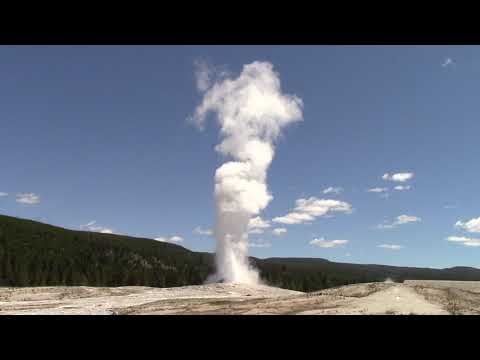

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('sNrWpRceoNo', width=600, height=400, start=20, end=100)

Here is the dataset of waiting time between eruptions and the duration of the eruption for the Old Faithful geyser. A data frame contains 272 observations on 2 variables:
* eruptions (numeric) -  eruption time in mins;
* waiting(numeric) -  waiting time to next eruption.

**Preparation**

Download the dataset in a csv format from github.
Following code should do the job.

In [0]:
# download the dataset
!wget https://raw.githubusercontent.com/fbeilstein/machine_learning/master/datasets/old_faithful.csv

**Problem 1**

Use pandas to load the `old_faithful.csv` file.
Complete the `read_dataframe()` function so that it returns DataFrame constructed from the `old_faithful.csv` file.
Start the "Visualize table" (uses `read_dataframe()` function) code to see what data it contains.

In [0]:
import pandas as pd

def read_dataframe():
  return pd.read_csv('old_faithful.csv')

In [0]:
#@title Visualize table
from google.colab import data_table
data_table.DataTable(read_dataframe(), include_index=False, num_rows_per_page=10)

**Problem 2**

Plot 'eruptions' vs 'waiting' scatter plot with matplotlib.
See if there is any pattern in the data.
Can GMM find any clusters here?
If yes, how many clasters is it reasonble to search for?

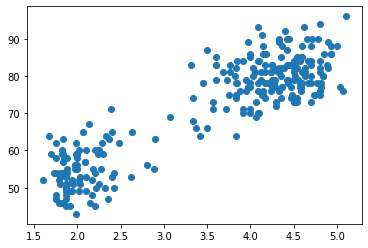

In [14]:
import numpy as np
e_ = np.array(f['eruptions'], dtype=float)
w_ = np.array(f['waiting'], dtype=int)

import matplotlib.pyplot as plt
plt.scatter(e, w);

**Problem 3**

Do GMM on the "old ant faithful".
You should implement `get_all_data()` function that returns datapoints `X`, their classes `y`, centers of gaussians `centers`, $2\times 2$ covariance matrices `covs`, and weights `w`.

In [0]:
from sklearn.mixture import GaussianMixture

def get_all_data():
  X = np.transpose(np.vstack([e_, w_]))
  gmm2 = GaussianMixture(2, covariance_type='full', random_state=0)
  gmm2.fit(X)
  y = gmm2.predict(X)
  centers = gmm2.means_
  covs = gmm2.covariances_
  w = gmm2.weights_
  return X, y, centers, covs, w

In [30]:
#@title Visualize GMM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
from matplotlib import cm

def draw_ellipse(position, covariance, ax, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
def plot_clusters(X, y, center, covariances, weights):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.set_xlim([np.min(X[:,0]), np.max(X[:,0])])
  ax.set_ylim([np.min(X[:,1]), np.max(X[:,1])])
  plt.axis('off')

  cmap = cm.get_cmap('viridis')
  c_norm = len(center)
  plt.scatter(X[:, 0], X[:, 1], c=y/c_norm, s=50)
  plt.scatter(center[:, 0], center[:, 1], c='red', marker='x', s=200, alpha=0.5);
  
  w_factor = 0.2 / weights.max()
  for pos, covar, w, c in zip(center, covariances, weights, range(c_norm)):
    clr = 0.5 if c_norm <= 1 else c/(c_norm-1)
    draw_ellipse(pos, covar, ax, alpha=w * w_factor, fc=cmap(clr))

  plt.close(fig)

  return fig

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from scipy.optimize import minimize


def get_surface_data(centers, covs, w, r):
  x_ = np.linspace(r[0], r[1], num=300)
  y_ = np.linspace(r[2], r[3], num=300)
  xx, yy = np.meshgrid(x_, y_)
  x_vec = np.transpose(np.vstack([xx.ravel(), yy.ravel()])) - centers[:, np.newaxis]
  prod_1 = np.array([np.dot(v,m) for v,m in zip(x_vec, np.linalg.inv(covs))])
  prod_2 = np.array([np.sum(v1*v2, axis=1) for v1,v2 in zip(prod_1, x_vec)])
  g = np.exp(-0.5 * prod_2) / np.sqrt(np.linalg.det(covs).shape) / 2.0 / np.pi
  g = g.reshape((g.shape[0], x_.shape[0], y_.shape[0]))
  G = np.sum(g*w[:,np.newaxis, np.newaxis], axis=0)
  C = np.argmax(g, axis=0)
  return x_, y_, G, C

def do_visuals():
  X, y_kmeans, centers, covs, w = get_all_data()
  x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
  y_min, y_max = np.min(X[:,1]), np.max(X[:,1])
  x_, y_, G, C = get_surface_data(centers, covs, w, [x_min, x_max, y_min, y_max])

  import base64
  import io

  figr = plot_clusters(X, y_kmeans, centers, covs, w)
  buf = io.BytesIO()
  figr.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = u'data:image/  png;base64,' + base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()


  fig = dict(
      layout = dict(
          width=1200, height=600, autosize=False,
          showlegend = False,
          scene = {'domain': { 'x': [0.0, 0.44], 'y': [0, 1] } },
          xaxis1 = {'domain': [0.55, 1], 'range': [x_min, x_max]},
          yaxis1 = {'domain': [0.0, 1.0], 'range': [y_min, y_max]},
          title  = 'GMM for old and faithful',
          margin = {'t': 50, 'b': 50, 'l': 50, 'r': 50},
          images = [{'source' : image_base64,
                    'xref': 'x', 'yref': 'y',
                    'sizing': 'stretch',
                    'sizex': x_max - x_min, 'sizey': y_max - y_min,
                    'layer': 'below', 'opacity':1.0,
                    'x': x_min, 'y': y_max}]
      ),
      data = [
          {'type': 'scatter3d', 'name': 's3', 'x': X[:,0], 'y': X[:,1], 'z': np.zeros(X.shape[0]), 
          'mode': 'markers', 'marker': {'size': 4, 'colorscale': 'Viridis', 'color': y_kmeans,
                                        'line': {'width': 2, 'color': 'rgba(0, 0, 0, 0.5)' }
                                        }},
          {'type': 'surface', 'name': 'f2', 'x': x_, 'y': y_, 'z': G, 'opacity': 0.8, 'showscale': False, 'surfacecolor': C, 'colorscale': 'Viridis'},
          #{'type': 'contour', 'name': 'c1', 'x':x_, 'y':y_, 'z':z_, 'contours': {'showlabels': True}},
          #{'type': 'scatter', 'name': 's2', 'x': _x, 'y': _y, 'line': {'color': 'red', 'width': 2}
          
      ]
  )

  #plot(fig, auto_open=False)
  f = go.Figure(fig)
  f.show()

do_visuals()